In [1]:
#imports
import os
import fitz
from sentence_transformers import SentenceTransformer
from typing import List, Tuple
import pandas as pd
from pacmap import PaCMAP
import numpy as np
import matplotlib.pyplot as plt 
import torch

c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
import os
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

In [3]:

#parameters
data_directory = "Data/"
chunk_size = 350
chunk_overlap = 0


In [4]:
#reading files
def read_txt(file_path): #reading .txt files
    with open(file_path, 'r') as f:
        content = f.read()
        f.close()
    return content


def read_pdf(file_path): #reading .pdf files
    document = fitz.open(file_path)
    text = ""

    for page_num in range(len(document)):
        page = document.load_page(page_num)
        text += page.get_text()
    return text

def read_file(file_path): #one function to read all supported file types
    _, file_extention = os.path.splitext(file_path)

    if file_extention.lower() == '.txt':
        return read_txt(file_path=file_path)
    elif file_extention.lower() == '.pdf':
        return read_pdf(file_path=file_path)
    else:
        return "Unsupported file type"


In [5]:
#storing the data as a corpus
def store_data(data_dir):
    data = []
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            data.append([file, read_file(os.path.join(root, file))])
    return data


def chunk_data(data, max_chunk_length=500):
    print("Chunking the data...")
    chunks = []
    for file in data:
        content = file[1]
        pdf_length = len(content)
        for i in range(pdf_length//max_chunk_length + 5):
            if content == "":
                break
            contentL = len(content)
            temp_length = min(max_chunk_length, contentL)
            temp_chunk = content[:temp_length]

            dotIndex = temp_chunk.rfind(". ")
            dotIndex2 = temp_chunk.rfind(".\n")
            qIndex = temp_chunk.rfind("? ")
            qIndex2 = temp_chunk.rfind("?\n")
            excIndex = temp_chunk.rfind("! ")
            excIndex2 = temp_chunk.rfind("!\n")
            entIndex = temp_chunk.rfind("\n")

            lastIndex = max(dotIndex, dotIndex2, qIndex, qIndex2, excIndex, excIndex2, entIndex)
            chunk = [file[0], content[:lastIndex]]
            content = content.replace(chunk[1], "", 1)
            chunks.append(chunk)
    return chunks

#embedding the chunks
model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_embeddings(chunks):
    print("Generating embeddings...")
    texts = [chunk[1] for chunk in chunks]
    chunk_embeddings = model.encode(texts)
    return list(zip([chunk[0] for chunk in chunks], chunk_embeddings))
    


In [6]:
#storing the embeddings in a vector DB
class VectorDB:
    def __init__(self):
        self.embeddings = []
        self.metadata = []

    def add_embeddings(self, embeddings: List[Tuple[str, List[float]]]):
        for source, embedding in embeddings:
            self.embeddings.append(embedding)
            self.metadata.append({"source": source})

    #using Euclidian distance for similarity search
    def _euclidean_distance(self, v1, v2):
        score = 0
        for i in range(len(v1)):
            score += (v1[i] - v2[i])**2
        return score * (1 / len(v1))

    def search(self, query_embedding: List[float], top_k: int = 5) -> List[Tuple[float, dict]]:
        if not self.embeddings:
            return []

        distances = [self._euclidean_distance(query_embedding, emb) for emb in self.embeddings]
        
        # Sort distances and get top_k (smallest distances)
        sorted_results = sorted(enumerate(zip(distances, self.metadata)), key=lambda x: x[1][0])

        return [{
            "distance": distance,
            "source": metadata['source'],
            "chunk index": index
        } for index, (distance, metadata) in sorted_results[:top_k]]

    #for seeing how many embeddings are in the vector store
    def __len__(self):
        return len(self.embeddings)
    
    #saving data to a .csv file
    def save(self, filepath: str):
        with open(filepath, 'w') as f:
            for embedding, metadata in zip(self.embeddings, self.metadata):
                embedding_str = ','.join(map(str, embedding))
                f.write(f"{metadata['source']},{embedding_str}\n")

    #loading data from a .csv file
    @classmethod
    def load(cls, filepath: str):
        vector_store = cls()
        with open(filepath, 'r') as f:
            for line in f:
                embedding_str = line.strip().split(',')
                source = embedding_str.pop(0)
                embedding = list(map(float, embedding_str))
                vector_store.embeddings.append(embedding)
                vector_store.metadata.append({"source": source})
        return vector_store


In [7]:
#main body of program
vector_store = VectorDB()
print("Reading Files...")
data = store_data(data_dir=data_directory)
chunked_data = chunk_data(data=data, max_chunk_length=chunk_size)

if not(os.path.exists("vector_store.csv")):    
    embeddings = generate_embeddings(chunked_data)
    vector_store.add_embeddings(embeddings=embeddings)
    print(f"Number of embeddings stored: {len(vector_store)}")
    vector_store.save('vector_store.csv')

else:
    shouldUpdate = input("Do you wish to update the DB? (y/n)")
    if shouldUpdate == 'y':
        embeddings = generate_embeddings(chunked_data)
        vector_store.add_embeddings(embeddings=embeddings)
        print(f"Number of embeddings stored: {len(vector_store)}")
        vector_store.save('vector_store.csv')

    else:
        vector_store = VectorDB.load('vector_store.csv')



Reading Files...
Chunking the data...


In [8]:
query = input('->')
query_embedding = model.encode([query])[0]

results = vector_store.search(query_embedding, top_k=3)

for result in results:
    print(f"Source: {result['source']}, Distance: {result['distance']:.4f}\n")
    print('\n'.join(chunked_data[result['chunk index']-1] + chunked_data[result['chunk index']] + chunked_data[result['chunk index']+1]))
    print()

Source: modern-cpp.pdf, Distance: 0.0016

modern-cpp.pdf

virtual void f() { cout << "A"; }
};
struct B : A {
void f() override { cout << "B"; }
};
A* get_object(bool selectA) {
return (selectA) ? new A() : new B();
}
void g(bool value) {
A* a = get_object(value);
B* b = dynamic_cast<B*>(a); // downcasting + check
if (b != nullptr)
b->f();
// exectuted only when it is safe
}
32/64
Operator
Overloading
modern-cpp.pdf

Operator Overloading
Operator Overloading
Operator overloading is a special case of polymorphism in which some operators
are treated as polymorphic functions and have diﬀerent behaviors depending on the
type of its arguments
struct Point {
int x, y;
Point operator+(const Point& p) const {
return {x + p.x, y + p.y};
}
};
Point a{1, 2};
modern-cpp.pdf

Point b{5, 3};
Point c = a + b; // "c" is (6, 5)
33/64
Operator Overloading
Category
Operators
Arithmetic
+
-
*
/
%
++
--
Comparison
==
!=
<
<=
>
>=
<=>
Bitwise
|
&
ˆ
∼
<<
>>
Logical
!
&&
||
Compound Assignment Arithmetic
+=
-

In [9]:
#my own PaCMAP

# vector_df = pd.read_csv("vector_store.csv", header=None)
# vector_df.columns = ['source'] + list(range(1, vector_df.shape[1]))

# labels = vector_df['source']
# vector_df = vector_df.drop(columns=['source'])

# labels = vector_store.metadata


# u_labels = list(set(labels[i]['source'] for i in range(len(labels))))

# num_labels = []
# for source in labels:
#     num_labels.append(u_labels.index(source['source']))

# pacmap = PaCMAP(n_components=2, n_neighbors=None, MN_ratio=.5, FP_ratio=2.0, random_state=1)

# X_transformed = pacmap.fit_transform(vector_df)

# plt.figure(figsize=(10, 8))
# plt.scatter(X_transformed[:, 0], X_transformed[:, 1], cmap='viridis',s=1 , c=num_labels)

In [10]:
#PaCMAP from hugging face

# vector_df2 = pd.read_csv("vector_store.csv", header=None)
# vector_df2.columns = ['source'] + list(range(1, vector_df2.shape[1]))

# labels = vector_df2['source']
# vector_df2 = vector_df2.drop(columns=['source'])

# documents_projected = pacmap.fit_transform(vector_df2, init="pca")

# labels = vector_store.metadata

# u_labels = list(set(labels[i]['source'] for i in range(len(labels))))

# num_labels = []
# for source in labels:
#     num_labels.append(u_labels.index(source['source']))

# df = pd.DataFrame.from_dict(
#     [
#         {
#             "x": documents_projected[i, 0],
#             "y": documents_projected[i, 1],
#             "source": num_labels[i],
#             "symbol": "circle",
#             "size_col": 4,
#         }
#         for i in range(len(documents_projected))
#     ]
# )

# plt.figure(figsize=(10, 8))
# fig = plt.scatter(
#     df['x'],
#     df['y'],
#     c=df["source"],
#     s=1,
# )

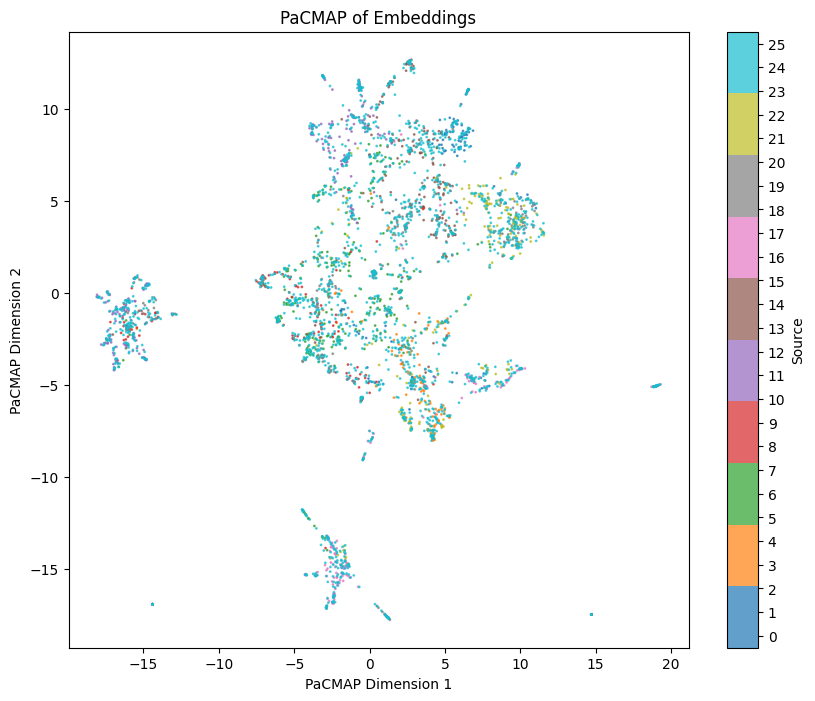

In [11]:
#PaCMAP from GPT4-o

embeddings_data = pd.read_csv('vector_store.csv', header=None)

sources = embeddings_data.iloc[:, 0]
embeddings = embeddings_data.iloc[:, 1:]
pacmap_model = PaCMAP()
embeddings_2d = pacmap_model.fit_transform(embeddings.values)

source_labels, unique_sources = pd.factorize(sources)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=source_labels, cmap='tab10', alpha=0.7, s=1)
plt.colorbar(scatter, ticks=range(len(unique_sources)), label='Source')
plt.clim(-0.5, len(unique_sources) - 0.5)
plt.title('PaCMAP of Embeddings')
plt.xlabel('PaCMAP Dimension 1')
plt.ylabel('PaCMAP Dimension 2')
plt.show()

In [12]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

In [13]:
tokenizer = T5Tokenizer.from_pretrained("t5-large")
llm_model = T5ForConditionalGeneration.from_pretrained("t5-large")

def generate_responses(query, retrieved_chunks, sources):
    prompt = f"""
    You are an LLM specifically designed to answer questions the user asks from provided context or create questions from them.
    You have to be very precise and tell the use where you got your info from.(this will be provided to you.)
    The user query is:

    {query}

    the context the user is talking about is:

    """

    for i in range(len(retrieved_chunks)):
        prompt += f"""
        The info is from {sources[i]} and it states: 
        
        {retrieved_chunks[i]}

        end of chunk.
        ---------------------------------------------

        """

    prompt += "Now answer the user query. If you can't answer then say you don't know."

    inputs = tokenizer(prompt, return_tensors="pt", truncation=True, max_length=2048)

    with torch.no_grad():
        outputs = llm_model.generate(**inputs, max_new_tokens=200, num_return_sequences=1)

    response = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return response

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
c:\Users\Lenovo\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Lenovo\.cache\huggingface\hub\models--t5-large. Caching files will still work but in a degraded version that might require more space on your disk. Th

In [14]:
while True:

    query = input('->')

    if query == "quit()":
        break

    query_embedding = model.encode([query])[0]

    results = vector_store.search(query_embedding, top_k=3)


    # for result in results:
    #     print(f"Source: {result['source']}, Distance: {result['distance']:.4f}\n")
    #     print('\n'.join(chunked_data[result['chunk index']-1] + chunked_data[result['chunk index']] + chunked_data[result['chunk index']+1]))
    #     print()

    retrieved_chunks = []
    retrieved_chunks_sources = []

    for result in results:
        retrieved_chunks.append('\n'.join(chunked_data[result['chunk index']]))
        retrieved_chunks_sources.append(result['source'])

    response = generate_responses(query=query, retrieved_chunks=retrieved_chunks, sources=retrieved_chunks_sources)

    print("\nResponse:", response)
    print("\n" + "-"*50 + "\n")

{'distance': 0.0035304803796920225, 'source': 'modern-cpp.pdf', 'chunk index': 1909}

Response: ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

--------------------------------------------------

{'distance': 0.001354465007733091, 'source': 'modern-cpp.pdf', 'chunk index': 3223}

Response: ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

--------------------------------------------------

